# STAT 426 Final Project
Isabelle Tooley
December 10, 2020

## Introduction

I am very interested in movies and stories. I always have been. But I assumed that my choice to pursue an education and career path in the field of statistics/data science meant that my love of words and storytelling would remain just a side interest. So I got very excited when I started learning about all the applications of natural language processing. It bridged two of my passions: statistics and stories.

Most stories are written. Books, scripts for plays and tv shows, movie screenplays: all of these are a collection of words that convey a story. The motivation for this project was to see if I could use some of those words to derive information about the story they represent. This is exciting to me because I think the entertainment industry is relatively uncharted territory for data science methods. Of course, this is beginning to change in the age of easy data accessibility and a desire for data-driven decisions in all industries. But still. If putting something like a movie script into a machine learning model can accurately spit out it's genre, theme, or general story-telling framework, then you could potentially reverse engineer it to start with a genre, theme, or story-telling framework and end up with a new movie script. This is super down the rabbit hole and sounds like *years* of research, but I think it's super cool and this project is as good a place to start as any.

The research question driving this project is essentially: **can the description of a movie (i.e. synopsis or plot summary), along with a handful of other variables, accurately predict the primary genre of a full-length film?** This will be a multinomial classification problem.

## Data

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import warnings
warnings.filterwarnings('ignore')

In [3]:
from nltk import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier

import xgboost
from xgboost import XGBClassifier

from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

### Collection

I use a combination of three datasets in this analysis. Two of them were collected from the [IMDb](https://www.imdb.com/interfaces/) website, the other was found on Kaggle [here](https://www.kaggle.com/cryptexcode/mpst-movie-plot-synopses-with-tags).

The first IMDb dataset is "title.basics.tsv". It contains some general information about the included media: the content type (short film, tv show, movie, etc.), primary title, release year, runtime, and others. Many of these variables won't be important during the modeling stage, but will be useful during the initial trimming down of the data. Most importantly, this dataset contains the **`genre`** field, which will be my target variable. Each observation/film is keyed with a unique IMDb id under the `tconst` field. These are essential to being able to combine the datasets.

The second IMDb dataset is "title.ratings.tsv". It contains only 3 variables: `tconst` (for merging), `averageRating` and `numVotes` which have information about the users' ratings of and votes for any particular title. Both of these will be used throughout the analysis.

The final dataset is called MPST for "movie plot synopsis with tags". This dataset contains much less observations than the other two, but it also has the most important feature - `plot_synopsis`. The text contains a summary of the movie, and it is my main objective to see if it is possible to accurately determine genre using primarily this information. Additionally, there is an `imdb_id` which I can use with the `tconst` variables from the first two datasets to facilitate merging.

I was able to download local copies of all three data files and read them directly into my notebook, which I do below. Then, I perform an innerjoin on the data to keep only the observations that are common between *all three* datasets.

In [13]:
## read in data
basics = pd.read_csv('title.basics.tsv', sep='\t')
ratings = pd.read_csv('title.ratings.tsv', sep='\t')
synopses = pd.read_csv('mpst_full_data.csv')

## merge all
all = pd.merge(left=pd.merge(basics, ratings, 'inner', on='tconst'), 
               right=synopses, how='inner', left_on='tconst', right_on='imdb_id')
all.head(3)

,tconst,titleType,primaryTitle,originalTitle,isAdult,startYear,endYear,runtimeMinutes,genres,averageRating,numVotes,imdb_id,title,plot_synopsis,tags,split,synopsis_source
0,tt0000091,short,The House of the Devil,Le manoir du diable,0,1896,\N,3,"Horror,Short",6.7,2859,tt0000091,Le manoir du diable,The film opens with a large bat flying into a ...,"paranormal, gothic",train,wikipedia
1,tt0000225,short,Beauty and the Beast,La belle et la bête,0,1899,\N,\N,"Family,Fantasy,Romance",5.1,18,tt0000225,La belle et la bête,A widower merchant lives in a mansion with his...,fantasy,train,wikipedia
2,tt0000230,short,Cinderella,Cendrillon,0,1899,\N,6,"Drama,Family,Fantasy",6.5,1358,tt0000230,Cendrillon,"A prologue in front of the curtain, suppressed...",fantasy,train,wikipedia


In [14]:
print('Number of movies with plot data:', synopses.shape[0])
print('Number of movies after merge:', all.shape[0])

Number of movies with plot data: 14828
Number of movies after merge: 14765


The original number of movies that had plot data was 14,828. During the innjerjoin to the IMDb datasets a handful of those observations were lost, leaving me with 14,765 titles that had basic, rating, and plot information.

### Cleaning

In this analysis I only want to consider full-length, non-adult films that were released later than 1950. So here I trim down the dataset accordingly and remove any unneccessary variables. The `tconst` id field was only useful as far as merging data, so that will no longer be needed. Although the `primaryTitle` variable will not be included in any useful analysis, I've kept it momentarily for context.

In [16]:
## filter down to only non-adult movie content that came out after 1950
movies = all[(all['titleType'] == 'movie') & 
             (all['isAdult'] == 0) & 
             (all['startYear'].astype(int) > 1950)]

## drop unnecessary variables
movies.drop(['tconst', 'titleType', 'originalTitle', 'isAdult', 'startYear',
             'endYear', 'imdb_id', 'title', 'tags', 'split', 'synopsis_source'],
            axis = 1, inplace = True)
movies.head()

,primaryTitle,runtimeMinutes,genres,averageRating,numVotes,plot_synopsis
756,Kate & Leopold,118,"Comedy,Fantasy,Romance",6.4,78334,"On 28 April 1876, Leopold, His Grace the 3rd D..."
1336,The Franchise Affair,88,"Crime,Drama,Mystery",7.1,206,"Robert Blair, a local solicitor, is called on ..."
1342,Halls of Montezuma,113,"Action,Adventure,Drama",6.6,2458,"During World War II, a Marine battalion prepar..."
1349,Diary of a Country Priest,115,Drama,7.9,9949,An idealistic young priest arrives at Ambricou...
1382,Under the Gun,83,"Crime,Drama,Film-Noir",6.8,117,"At a Miami nightclub, gangster Bert Galvin off..."


#### Missing values
Missing values are represented in the data by a '\N' character. Some of these can be imputed, like `runtimeMinutes` which will be replaced with the variable mean. The one missing genre field will be dropped because it's the target variable and we need to know what it is. I also drop duplicate observations.

In [17]:
## count missing values
(movies == '\\N').sum()

primaryTitle       0
runtimeMinutes    28
genres             1
averageRating      0
numVotes           0
plot_synopsis      0
dtype: int64

In [18]:
## replace \N strings with NaNs
movies.replace(to_replace = '\\N', value = np.nan, inplace = True)

## make runtimeMinutes numeric, fill NAs with the mean
movies['runtimeMinutes'] = pd.to_numeric(movies['runtimeMinutes'])
movies['runtimeMinutes'].fillna(movies['runtimeMinutes'].mean(), inplace = True)

## drop remaining NAs and any duplicate movies/plots
movies_clean = movies.dropna().drop_duplicates(['primaryTitle', 'plot_synopsis'])

## reformat
movies_clean.reset_index(drop = True, inplace = True)

#### Refine Genre
Firstly, I clean the `genre` field by selecting the first listed genre. This is under the assumption that the first is the main genre. It is possible that this is not the best assumption, but for simplifying purposes it will do. Below we can see that there are 20 unique genres represented in the data, with varying frequencies.

In [19]:
## extract the main genre (assume it is the first listed)
movies_clean['genre'] = movies_clean['genres'].apply(lambda x: re.findall('\w+', x)[0])
movies_clean.drop(['genres'], axis = 1, inplace = True)
movies_clean.head()

print('Number of unique primary genres:', movies_clean['genre'].nunique())
print('Number of movies of each genre:')
print(movies_clean['genre'].value_counts())

Number of unique primary genres: 20
Number of movies of each genre:
Action         2592
Comedy         2390
Drama          2075
Horror          998
Crime           978
Adventure       778
Biography       434
Animation       118
Western          95
Fantasy          89
Mystery          65
Documentary      62
Sci              37
Thriller         34
Romance          31
Family           23
Musical          15
Music             3
Film              1
History           1
Name: genre, dtype: int64


I want to consider only a few genre categories. My original approach to this step of cleaning was to create 7 classes: the 6 genres with more than 500 appearances in the data and a 7th "Other" category which would be all the remaining genres lumped together. After pursuing this for a little bit I realized that there were too many classes to deal with.

Instead, I decided on three main classes that seemed distinct from each other (to avoid blurred lines like those between action and adventure movies). My thought was that selecting genres with natural differences between theme, plot structure, and events would aid in modeling. These three classes are:

1. Action
2. Comedy
3. Horror

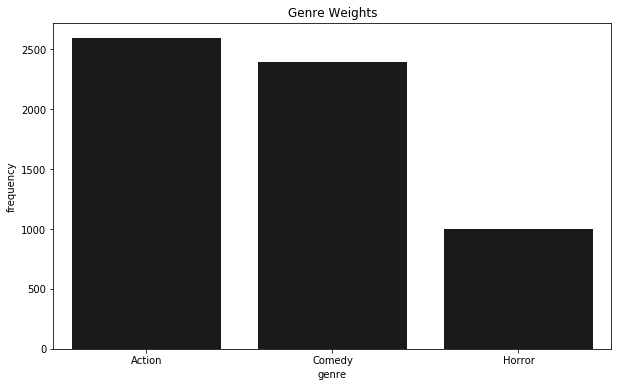

In [40]:
## keep only movies of the three genres of interest
movies_keep = movies_clean[(movies_clean['genre'] == 'Action') |
                           (movies_clean['genre'] == 'Comedy') |
                           (movies_clean['genre'] == 'Horror')].reset_index(drop=True)

genre_freq = pd.DataFrame(movies_keep['genre'].value_counts())
genre_freq

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=['Action', 'Comedy', 'Horror'], y=genre_freq.iloc[:,0],
            label='Total', color='k')
ax.set(ylabel="frequency",
       xlabel="genre",
       title="Genre Weights")
f.show()

The plot above shows the number of Action, Comedy, and Horror movies present in the data. While Action and Comedy appear at somewhat equal amounts, the Horror class is definitely the minority. It might be important to keep class imbalance effects in mind as we continue to modeling. However, I won't address it at this point because hopefully the data overall is not at a scale where imbalance would cause a noticeable problem.

At this stage of the cleaning process, I am left with about 6,000 complete observations. This is a decent sample size, so I'm not concerned about having over-filtered my data.

### Text Cleaning and Feature Engineering

Below I have defined a list of stopwords and a basic function called "clean_text" to process the `plot_synopsis` text data. All characters are standardized to the lowercase, tokenized by word, removed if non-alphanumeric or a stopword, and rejoined to a readable format.

In [16]:
## stopwords
sw = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 
      'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 
      'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
      'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
      'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
      'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
      'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
      'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
      'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
      'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't",
      'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn',
      "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't",'isn', 
      "isn't", 'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', 
      "shouldn't", 'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't", "from", "subject"]

## function to clean
def clean_text(x):
    x = x.lower()
    tokens = word_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    return " ".join(tokens)

### Top Words by Genre

As part of my EDA, I want to look at the Top 10 Words of each genre's plot.

In [18]:
## clean synopses for movies in all the individual genres, use this to determine the top words in each genre
cleaned_action = movies_keep[movies_keep['genre'] == 'Action']['plot_synopsis'].apply(lambda x: clean_text(x))
cleaned_comedy = movies_keep[movies_keep['genre'] == 'Comedy']['plot_synopsis'].apply(lambda x: clean_text(x))
cleaned_horror = movies_keep[movies_keep['genre'] == 'Horror']['plot_synopsis'].apply(lambda x: clean_text(x))

In [19]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_action)
freq_df_action = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_action = freq_df_action.sum(axis=0).sort_values(ascending=False).reset_index()
top_action.iloc[0:10,0]

0      one
1    tells
2     back
3      two
4      man
5      get
6      men
7      car
8     find
9     kill
Name: index, dtype: object

In [20]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_comedy)
freq_df_comedy = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_comedy = freq_df_comedy.sum(axis=0).sort_values(ascending=False).reset_index()
top_comedy.iloc[0:10,0]

0    tells
1      one
2     back
3      get
4      two
5       go
6     home
7     says
8    house
9      new
Name: index, dtype: object

In [21]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(cleaned_horror)
freq_df_horror = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_horror = freq_df_horror.sum(axis=0).sort_values(ascending=False).reset_index()
top_horror.iloc[0:10,0]

0    tells
1     back
2    house
3      one
4     room
5      man
6     goes
7     find
8    finds
9     says
Name: index, dtype: object

After cleaning the text by the defined function, I noticed that there are a lot of similarities in the top words for these three genres. Just by looking at the three lists above, it would be extremely difficult to tell which words were important to which genre. And these are supposed to be my key features! So this needs some work.

### A NEW Cleaning Function

My solution is to create another list of "stopwords", but for plot. Essentially, these are words that are common to all types of storytelling and provide no real value when it comes to distinguishing between genre. Words like "tells" and "says", "man" and "woman", "went" and "goes" - these are words that every single written story depends on.

Below I find the Top 200 Common story words between all three genres. Then I make those into a list and similar to how the list of stopwords are used, I remove those from the plot text in my new cleaning function. I don't believe that this is cheating or coding bias into my data, it's just accentuating the differences that are already there.

In [22]:
## find common words between all genres
common_pw = pd.merge(left=pd.merge(left=top_action, right=top_comedy, how='inner', on='index',
                                   suffixes=('_action', '_comedy')),
                     right=top_horror, how='inner', on='index')
common_pw['total'] = common_pw.iloc[:,1] + common_pw.iloc[:,2] + common_pw.iloc[:,3]

## take top 200
most_common_pw = common_pw.sort_values(ascending=False, by='total').iloc[0:200,0]

In [23]:
## list of 200 plot words that are most common between all three genres
hifreq_pw = list(most_common_pw)

## function to clean
def new_clean_text(x):
    x = x.lower()
    tokens = word_tokenize(x)
    tokens = [tok for tok in tokens if tok.isalnum()]
    tokens = [tok for tok in tokens if tok not in sw]
    tokens = [tok for tok in tokens if tok not in hifreq_pw]
    return " ".join(tokens)

### Top Words by Genre: TAKE TWO

In [24]:
new_cleaned_action = movies_keep[movies_keep['genre'] == 'Action']['plot_synopsis'].apply(lambda x: new_clean_text(x))
new_cleaned_comedy = movies_keep[movies_keep['genre'] == 'Comedy']['plot_synopsis'].apply(lambda x: new_clean_text(x))
new_cleaned_horror = movies_keep[movies_keep['genre'] == 'Horror']['plot_synopsis'].apply(lambda x: new_clean_text(x))

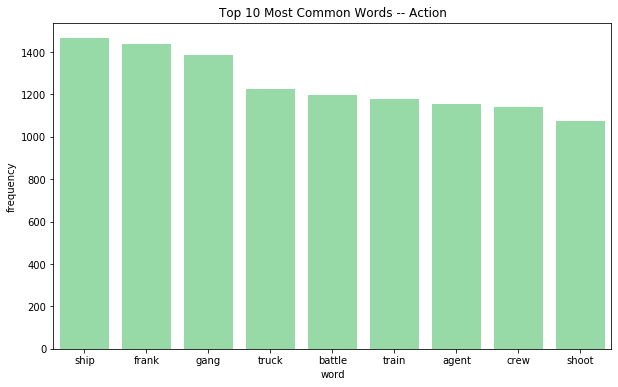

In [25]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_action)
freq_df_action = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_action = freq_df_action.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_action.iloc[0:9,0], y=top_action.iloc[0:9,1],
            label="Total", color="g")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Action")
f.show()

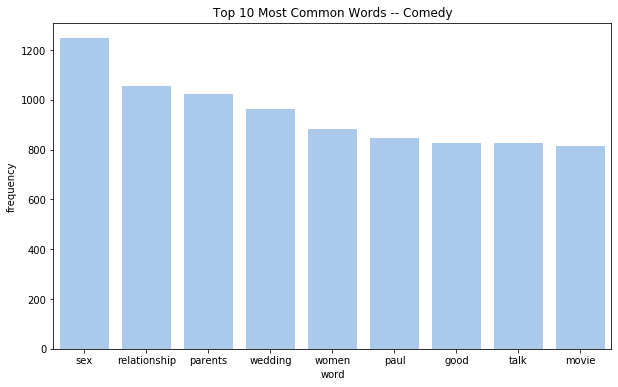

In [26]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_comedy)
freq_df_comedy = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_comedy = freq_df_comedy.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_comedy.iloc[0:9,0], y=top_comedy.iloc[0:9,1],
            label="Total", color="b")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Comedy")
f.show()

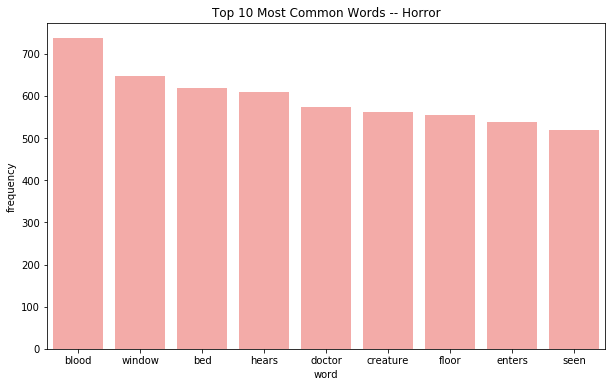

In [27]:
cnt = CountVectorizer(min_df=0.05)
wrd_freq = cnt.fit_transform(new_cleaned_horror)
freq_df_horror = pd.DataFrame(wrd_freq.toarray(), columns=cnt.get_feature_names())
top_horror = freq_df_horror.sum(axis=0).sort_values(ascending=False).reset_index()

f, ax = plt.subplots(figsize=(10, 6))
sns.set_color_codes("pastel")
sns.barplot(x=top_horror.iloc[0:9,0], y=top_horror.iloc[0:9,1],
            label="Total", color="r")
ax.set(ylabel="frequency",
       xlabel="word",
       title="Top 10 Most Common Words -- Horror")
f.show()

These Top 10 Words by genre look a lot better now!! I feel comfortable applying the new text cleaning function to the entire ordered dataset.

In [28]:
## clean all text
cleaned_plot = movies_keep['plot_synopsis'].apply(lambda x: new_clean_text(x))

#### TF-IDF Scores
Finally, I calculate tf-idf scores for the remaining text of the plot. This is a method of turning text into something that a model can actually use by assigning weights to words.

In [29]:
## calculate tf-idf scores
tf = TfidfVectorizer(max_df=.99, min_df=.01)
X_plot = tf.fit_transform(cleaned_plot)
plot_tfidf = pd.DataFrame(X_plot.toarray(), columns=tf.get_feature_names())
plot_tfidf.head()

,10,100,11,12,15,18,20,200,24,25,...,yells,yes,yet,york,younger,youngest,youth,zombie,zombies,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.071144,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


### Additional EDA

I also would like to get an idea of what my three additional variables look like. Violin plots are made to view the distribution of `runtimeMinutes`, `averageRating`, and `numVotes` for each genre. The idea in including these variables is that different types of movies might require a different amount of time to tell the story and that users consistently rate or vote for certain kinds of movies differently than others. 

However, after reviewing the plots below, it looks like there isn't that much of a difference in these features between genres. They could just be adding noise, but I'll keep them regardless.

#### runtimeMinutes

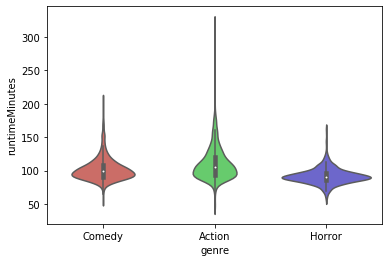

In [30]:
## violin plots for runtime by genre
sns.violinplot(x="genre", y="runtimeMinutes", palette='hls', data=movies_keep)

#### averageRating

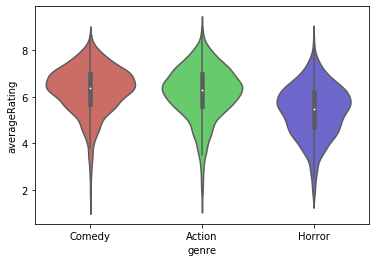

In [31]:
sns.violinplot(x="genre", y="averageRating", palette='hls', data=movies_keep)

#### numVotes

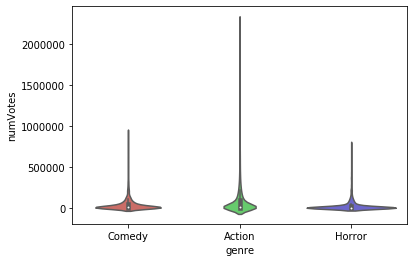

In [32]:
sns.violinplot(x="genre", y="numVotes", palette='hls', data=movies_keep)

### K-Means Clustering and PCA

In addition to some basic EDA, I include here a short cluster analysis on the data before moving into the modeling stage of the project.

Below, I scale the three numeric features using the MinMaxScaler (leaving tf-idf scores alone). Then I combine the scaled data and tf-idf scores, maintaining their proper ordering, and perform K-Means cluster analysis.

In [30]:
## instantiate, fit, and transform the minmaxscaler on runtime, rating, and votes features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(movies_keep[['runtimeMinutes', 'averageRating', 'numVotes']])
scaled_X = pd.DataFrame(data=scaled, columns = ['runtimeMinutes', 'averageRating', 'numVotes'])

In [31]:
## combine scaled features with tf-idf scores from the synopsis text
X_df = pd.concat([scaled_X, plot_tfidf], axis=1, join_axes=[scaled_X.index])
X_df.head()

,runtimeMinutes,averageRating,numVotes,10,100,11,12,15,18,20,...,yells,yes,yet,york,younger,youngest,youth,zombie,zombies,zone
0,0.264493,0.657895,0.034509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.071144,0.0,0.0,0.0,0.0,0.0,0.0
1,0.246377,0.684211,0.001078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.130435,0.697368,0.000512,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.130435,0.671053,0.000256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.260870,0.776316,0.002661,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [36]:
## k-means cluster analysis for multiple values of k
wcss = []
for k in range(1,10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(X_df)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'WCSS')

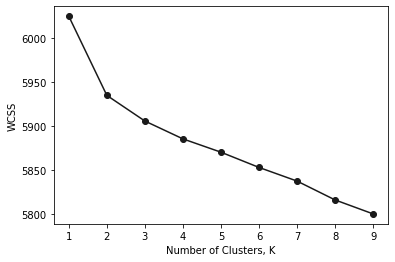

In [37]:
## make elbow plot (theoretically, the optimal value of k should be at 3)
plt.plot(np.arange(1,10), wcss, 'ok-')
plt.xlabel('Number of Clusters, K')
plt.ylabel('WCSS')

After evaluating the within-cluster sum of squares for various levels of k, I determined that there is a local elbow at `k=2`. However, knowing that there are 3 true clusters (for the 3 genre classes) present in the data, I will move ahead with the nearby `k=3` and look at those cluster centers.

In [38]:
## fit k-means and determine the cluster centers
km = KMeans(n_clusters=3, random_state=80109)
km.fit(X_df)
centers = pd.DataFrame(km.cluster_centers_, columns=X_df.columns)

## determine top features from each cluster
order_centroids = km.cluster_centers_.argsort()[:,::-1]

for i in range(3):
    print("Cluster %d:" % i, end='\n')
    for ind in order_centroids[i, :10]:
        print(' %s' % X_df.columns[ind] + ': ' + 
              str(round(centers.loc[i, X_df.columns[ind]], 3)), end='\n')
    print()

Cluster 0:
 averageRating: 0.763
 runtimeMinutes: 0.262
 numVotes: 0.053
 bond: 0.013
 gang: 0.012
 frank: 0.012
 train: 0.012
 harry: 0.011
 ship: 0.011
 sam: 0.011

Cluster 1:
 averageRating: 0.383
 runtimeMinutes: 0.177
 girls: 0.011
 johnny: 0.01
 attacked: 0.01
 creature: 0.009
 zombies: 0.009
 sister: 0.009
 vampire: 0.009
 blood: 0.009

Cluster 2:
 averageRating: 0.608
 runtimeMinutes: 0.194
 numVotes: 0.015
 joe: 0.011
 paul: 0.011
 sam: 0.01
 nick: 0.01
 gang: 0.01
 mike: 0.01
 ben: 0.009



By looking at the centroids for each cluster, it is possible to see themes within them. 
- **Cluster 0** has higher average ratings, runtimes, and number of votes and key plot words are similar to the Top 10 Action Words. It is likely that this cluster is capturing action movies.
- **Cluster 1** has the lowest average ratings and key plot words that are similar to the Top 10 Horror Words. It is likely that this cluster is capturing horror movies.
- **Cluster 2** has the second highest average ratings, runtimes, and number of votes. The key plot keywords are just names, which is kind of funny. If this cluster represents Comedy movies, we can see why that might be the case. Many comedy movies have a lot of characters because they're based on families or groups of friends and the reality and events of their lives. Names, groups, places of gathering, etc. might be more important than descriptions of explosions or paranormal events.

As a final step in exploring the data, I also want to look at the first two principal components to make sure that there is good separation between the genres.

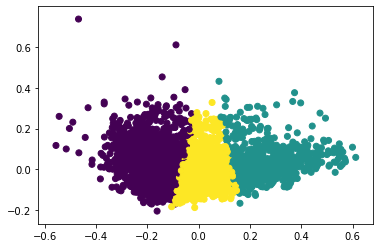

In [39]:
## look at first 2 principle components colored by cluster label
pca = PCA(n_components=2, random_state=80109)
pca.fit(X_df)
prnc_comp = pca.transform(X_df)
plt.scatter(prnc_comp[:,0], prnc_comp[:,1], c=km.labels_)

A quick look at the first two principal components of the fully processed data indicates that there is clear separation between clusters (the three genres that make up the target variable). That being said, there aren't clear clusters. The plot above just looks like one big blob. But the sharp definition between predicted clusters is encouraging.

Throughout the data cleaning process, I made an effort to select genres that would seem to be naturally distinct from each other. This could be argued and I of course acknowledge the overlap of themes or events in these types of movies; but Action, Comedy, and Horror films are different enough from each other in nature to perhaps lend themselves to analysis (instead of something like Action, Adventure, and Drama). Additionally, creating an expansive list of plot "stop words," which are words that are common in storywriting, reinforced the already present differences between these genres.

I feel comfortable proceeding to the modeling section of this project, knowing that effort was made to make the target categories as distinct as possible.

## Methods and Results

Many machine learning models are unable to handle categorical target variables in their raw character form. Some can, but they are the exception rather than the rule. Encoding the class levels of the target as integers is the safest route. Below, I encode **Action as 1**, **Comedy as 2**, and **Horror as 3**. The scaled data and tf-idf scores (`X_df`) and the numeric genre field (`y_int`) are then split into train and test sets.

In [32]:
## encode genre categories as integers
y = movies_keep['genre']
y_int = pd.DataFrame(pd.factorize(y, sort=True)[0] + 1)

## split into 70/30 train/test
X_train, X_test = train_test_split(X_df, test_size = 0.3, random_state = 80109)
y_train, y_test = train_test_split(y_int, test_size = 0.3, random_state = 80109)

print('Train Set dimensions (X/y):', X_train.shape, '/', y_train.shape)
print('Test Set dimensions (X/y):', X_test.shape, '/', y_test.shape)

Train Set dimensions (X/y): (4186, 5017) / (4186, 1)
Test Set dimensions (X/y): (1794, 5017) / (1794, 1)


### Model Discussion

The four classification models that I will experiment with are:

1. **Logistic Regression** with a one vs rest (also known as one vs all) approach for the multi-class problem. This is the most basic approach to classification problems, but it's still powerful. I first learned about it in STAT 330, so I wanted to see how well it holds up for a much more complex problem than simple binary classification.
    - **Strengths**: easy implementation, fast, probabilistic approach to class assignments (interpretable), overfitting is only possible if there are more classes than observations
    - **Weaknesses**: dependent on linearity assumptions (on the log odds scale), not robust enough to detect complex patterns in data


2. **Multinomial Naive Bayes**. This is always a good choice when you're in the stage of playing around with various machine learning models. It is also one of the go-to algorithms for text classification.
    - **Strengths**: easy implementation, fast, can handle large amounts of training data, reliable Bayesian process of using data to calculate posterior class probabilities and making predictions based on that (interpretable), direct handling of multiple classes, hard to overfit
    - **Weaknesses**: assumes total independence between features, assumes that the features follow a common distribution, not good for ill-defined boundaries between classes, direct handling of multiple classes
    

3. **Random Forest**. This was a model that I chose to play around with just kind of out of obligation. I haven't see instances where a random forest outperforms an algorithm that is based on it (like a gradient boosted classifier), but I wanted to see how well it could do on this text data compared to other models that might be more suited for this kind of problem. But I will always think that the idea of random forests is very cool.
    - **Strengths**: as an ensemble model predictions are made by committee so class assignments will never be at the mercy of a few biased trees, preserves a level of interpretability and feature importance by keeping track of the features that made the best splits, allows for relationships between features, it's a Classic :)
    - **Weaknesses**: frequent overfitting, longer training period
    
    
4. **Extreme Gradient Boosting (XGBoost)**, which is built upon the Random Forest algorithm. I chose this as the last model to experiment with because it is one of my personal go-to's for any data science problem. These models are extremely popular and are the winners of most Kaggle competitions. Also, the general idea of iteratively training trees that can make up for the weaknesses of the ones before them is super smart. As an ensemble model, all of these learners that essentially "specialize" in some part of the classification problem can work together to make really good predictions.
    - **Strengths**: stable, self-improving algorithm, good for well-defined data and complex data, very robust
    - **Weaknesses**: big black box, very long training period, tendency to overfit, lots of hyperparameters to try and understand and tune (however the ability to tune could also be seen as an advantage)

### Performance Benchmarks

Below, I have made a list of instantiated models with some basic parameter settings (some required to handle a multi-class problem, others to shorten the training period). All four of these models will be trained and validated using a 10-fold cross-validation approach. CV accuracy scores will be a good initial benchmark of out-of-sample model performance.

In [98]:
## instantiate a list of models
models = [LogisticRegression(random_state=80109, multi_class='ovr'),
          MultinomialNB(),
          RandomForestClassifier(n_estimators=100, min_samples_split=3, random_state=80109),
          XGBClassifier(objective='multi:softmax', eval_metric='merror', max_depth=5, random_state=80109)]

## train using cross validation
print('Average Accuracy Scores \n')
for model in models:
    accuracies = cross_val_score(model, X_train, y_train, cv=10, scoring='accuracy')
    print('10-fold CV -', model.__class__.__name__, ': ', accuracies.mean())

Average Accuracy Scores 

10-fold CV - LogisticRegression :  0.7856873095122239
10-fold CV - MultinomialNB :  0.7579840634692118
10-fold CV - RandomForestClassifier :  0.7649264548804482
10-fold CV - XGBClassifier :  0.7890520516863506


Based on these cross-validated accuracy scores, the **XGBClassifier** performs better than all others, followed closely by the Logistic Regression model (within a couple thousandths).

### Improving Model Performance

#### Tuning Parameters

We will continue with the best model, the **XGBClassifier**. Here I will use a grid search with cross-validation training to assess the model's performance for different levels of its unique hyperparameters. I start with a tuning grid encompassing a reasonably wide range of the following parameters.

* `eta - [0.2]`: This is the learning rate, or the weights assigned to incorrectly classifications from the previous iteration. I have chosen 0.2 because it is a slower learning rate than the default, but not too slow as to signifcantly extend the training period.

* `max_depth - [3, 5, 7, 9]`: This is the maximum depth of each tree. To control overfitting these should be kept to small values. Additionally, purposefully "stunting" the tree could allow for following models to improve upon it to a greater degree, so I have selected a wide range of max_depths to test.

* `subsample - [0.9]`: This controls the fraction of the data that will be sampled to train each tree. Lower values can prevent overfitting and reduce training time, but too low and the model will be underfit.

* `colsample_bytree - [0.6, 0.8, 1]`: This parameter determines the number of columns/features to be randomly selected for training trees.

#### Evaluation Criteria

For evaluating each iteration of the model, I use the **F1 Micro Score**. For multinomial, or multi-class, problems this metric is determined by calculating the recall and precision scores for all the samples together, and then combining them as a harmonic mean to get the F1 Micro score. Because of the way the math works out, the following is always true for the micro-F1 metric: `micro-F1 = micro-precision = micro-recall = accuracy`. So this one evaluation can be used to assess multiple metrics at once. I learned about this from [this](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1) blog post.

Also, there aren't very strong consequences for different kinds of classification errors when it comes to predicting genre. So focusing on maximizing one of precision or recall didn't seem to have any particular advantage over defining "better" models as the ones that have similar precision and recall capabilities, which the F1 Score captures well.

In [34]:
## define tuning grid
tune_grid = {'eta': [0.2],
              'max_depth': [3, 5, 7, 9],
              'subsample': [0.9],
              'colsample_bytree': [0.6, 0.8, 1]}

## create xgbcl object
xgb = XGBClassifier(objective='multi:softmax', eval_metric='merror', random_state=80109)

## define cross-validated grid search, fit
grid_search = GridSearchCV(estimator=xgb, param_grid=tune_grid, cv=5, scoring='f1_micro')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     eval_metric='merror', gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=...
                                     random_state=80109, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
                                     subsample=None, tree_method=None,
                                     use_label_encoder=True,
  

#### Best Tune
The results of the best model found during the grid search are provided below. With a micro-F1 score of about 79%, the highest performing XGBClassifier had the parameters `colsample_bytree = 0.6`, `eta = 0.2`, `max_depth = 9`, `subsample = 0.9`.

For further improvements to this model, additional tuning should be centered around these values to close in on the most optimal model settings. This is an essential part of the data science pipeline. After data cleaning, visualization/exploration, feature cleaning, pre-processing, etc. it becomes a process of moving back and forth between modeling and model validation. After a model is trained and its performance evaluated, we go back and train another model with better parameter values. I won't do that here because I have already demonstrated the process of applying a grid search to determine the optimal parameters for a specific model and the available data. And this notebook is getting long :) However, that is what I would do if I were interested in fine-tuning this model even more.

In [41]:
## best model info
print('Micro F1 =', grid_search.best_score_)
print(grid_search.best_params_)

Micro F1 = 0.7914476827520306
{'colsample_bytree': 0.6, 'eta': 0.2, 'max_depth': 9, 'subsample': 0.9}


### Model Performance Summary

Predictions are made on the `X_test` set using the best model from the grid search above. The report of model performance following these predictions are a measure of the model's ability to classify new, entirely out-of-sample data.

In [77]:
## predict on test set
best_xgb = grid_search.best_estimator_
y_preds = best_xgb.predict(X_test)

In [86]:
print(accuracy_score(y_test, y_preds))

0.8015607580824972


#### Confusion Matrix

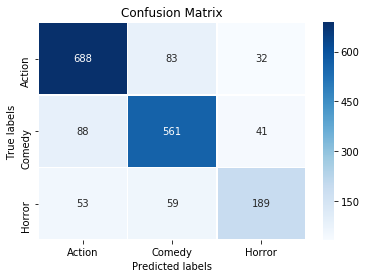

In [88]:
## look at confusion matrix
cnf_mat = confusion_matrix(y_test, y_preds)

ax = plt.subplot()
sns.heatmap(cnf_mat, annot=True, fmt='d', cmap='Blues', linewidths=0.5, ax = ax)
b, t = plt.ylim()
b += 0.5 # increase margin at the bottom
t -= 0.5 # decrease margin at the top
plt.ylim(b, t)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Action', 'Comedy', 'Horror'])
ax.yaxis.set_ticklabels(['Action', 'Comedy', 'Horror'])
plt.show()

A confusion matrix is a good picture of correct and incorrect classifications. At first glance, we can see that the majority of the classifications lie on the diagonal, meaning that the bulk of class predictions were correctly assigned to the true class. This is good! However, there are definitely still some misclassifcations present, most prevalently in the Horror genre.

We could calculate some performance metrics using the cell frequencies. For example, $accuracy = \frac{total\ correct\ classifications}{total\ classifications\ made}$ and $precision = \frac{true\ positives}{total\ positive\ classifications}$. However, it is easier to look at the automatic summary generated in the next section.

#### Overall Summary

The `classification_report` function from the `sklearn.metrics` library is an excellent way of getting a big picture view of model performance. Class precision, recall, and f1-scores are reported. But so are the averages for these metrics over all classes.

In [81]:
print(classification_report(y_test, y_preds, target_names=['Action', 'Comedy', 'Horror']))

              precision    recall  f1-score   support

      Action       0.83      0.86      0.84       803
      Comedy       0.80      0.81      0.81       690
      Horror       0.72      0.63      0.67       301

    accuracy                           0.80      1794
   macro avg       0.78      0.77      0.77      1794
weighted avg       0.80      0.80      0.80      1794



This model performance summary shows that Action movies are correctly classified the most out of all genres, while Horror movies fall 10-20% behind in all metrics. There is likely some underlying bias in the data that makes Action and Comedy movies easier to successfully predict than Horror movies. Maybe the effects of a class imbalance, where the model is trained to "favor" the majority class simply because it has more information.

Additionally, there is an overall accuracy (and micro-F1) score about 80%. Honestly, this is a lot better than I was expecting! I'm very pleasantly surprised.

#### Revisit Research Question
Based on these performance summaries and returning to my original research question, I feel confident saying that it is completely reasonable to predict with relatively high accuracy the main genre of a movie using primarily it's synopsis.

## Conclusions

### Takeaways

The most important takeaway from this analysis is that written content associated with stories, particularly movies and plot synopses, is a viable approach to determining the overall genre of the film. There is information encoded in the words that make up stories that give it certain characteristics, and it is possible to detect and utilize those patterns.

Another takeaway is that Logistic Regression is still relevant!! In this world of machine learning and all these complex, black-box algorithms available to process data, it's kind of reassuring to know that basic statistical procedures have held their value and still apply. I was amazed to see that not only did it out-perform other methods like Naive Bayes and Random Forests, but it lost to the XGBClassifier by a *thread*. I'll remember that. To not overlook simple solutions just because they're simple.

Something that I'm kind of proud of are the unique problems and the solutions I came up with. Specifically, the part of the text cleaning where I created another list of plot stopwords to reinforce class trends. It also reinforced in me the importance of exploring your data at all stages. If I had not looked at the Top 10 words for each genre, I might not have realized that the original approach to refining the plot text wasn't good enough. I would not have known that there was something else that I could do to improve my model before I even got to modeling.

A final takeaway is to look for opportunities to include unsupervised learning in data science projects. It's a good way to get an idea of what your data looks like and what the patterns are. For me, the K-Means and PCA sections served as a kind of sanity check to make sure that there was separation between genres. There's a lot you can do before modeling to make sure that modeling is as successful as possible.

### Limitations and New Questions

One of the first things I want to acknowledge is that my main assumption (that the first listed genre is the primary genre) might be subject to argument. After further exploration, I found that it is also extremely likely that movies with multiple genre assignments list them alphabetically. So for a theoretical Action and Comedy movie, my model would only understand it as action, possibly conflating the action and comedy clues in the text. However, a counter argument to that is if Comedy is listed first, then it is truly a comedy movie and has very little elements of action. If Horror is listed first, it is most likely a true horror movie because it wasn't preceded by action or comedy. Either way, I felt like that issue should be noted.

Another limitation could be class imbalance in the data. There are many more Action and Comedy movies (around 2,000 each) than there are Horror movies (about 800). It could be worth investigating procedures to help the model in successfully classifying the Horror genre, as the evaluation summaries from the previous section showed that that is an area of struggle. Things like up-sampling the minority class, down-sampling the majority class, or a hybrid of those could all be used to try and address the imbalance.

It could aslo be possible that adding in the extra variables `runtimeMinutes`, `averageRating`, and `numVotes` adds too much noise to the most important information derived from the plot text. In a quick exploration of those three variables, they didn't appear to be very different between genres and it is likely that they aren't very helpful in making classifications. They could hurt the model instead of help it. It could be worth exploring how well the genres separate, and how well my models can predict, with just the movie synopses. Can classifications be made just as well (or better) using just plot information?